<a href="https://colab.research.google.com/github/StratosFair/Mean_Escape_Time/blob/main/Duffin_oscillator/Models/boundary_pinn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
from torch.nn import ReLU
from torch.utils.data import Dataset, DataLoader
from functools import partial
import matplotlib.pyplot as plt
import numpy as np
import random

# Solving for the MET of a Duffing oscillator process in a disk with "Boundary Adapted PINNs": computation of solutions using Finite Element Method

Based on the paper [A neural network solution of first-passage problems](https://link.springer.com/article/10.1007/s10483-024-3189-8) (Jiamin Qian, Lincong Chen & J. Q. Sun, Oct. 2024), the 2-dimensional Duffing oscillator is defined by:
$$ d \begin{pmatrix} X_1(t)\\
X_2(t) \end{pmatrix} = \begin{pmatrix} X_2\\
-X_1 - X_1^3 - 2\zeta X_2 \end{pmatrix} dt + \begin{pmatrix} \sqrt{2\varepsilon}dB_1(t)\\
\sqrt{2\zeta} dB_2(t) \end{pmatrix}$$

The infinitesimal generator of this process is given for sufficiently smooth $f$ by
$$\mathscr Lf: x \mapsto b(x) \cdot \nabla f(x) + a(x) : \nabla^2 f(x)$$
where
$$b : x = (x_1, x_2)^T \mapsto \begin{pmatrix} x_2\\ -x_1 - x_1^3 - 2\zeta x_2 \end{pmatrix}  $$
and
$$a:x \mapsto \frac12 \sigma(x)\sigma(x)^T = \begin{pmatrix} \varepsilon & 0\\ 0 & \zeta\end{pmatrix} $$

Let $\Omega := B_r \equiv \{x\in\mathbb R^d : \|x\|< r \}$, and for all $x\in\Omega$, let

$$T(x) := \inf\{t\ge 0 : X_t \in\partial\Omega\} $$

and let its first moment be denoted

$$\tau(x) := \mathbb E[T(x)] $$

We can show under some regularity conditions on the coefficients $a$ and $b$ that $\tau:\Omega \to \mathbb R$ is the (unique) solution of the BVP :

$$\begin{cases}\mathscr L\tau = -1 \quad \text{in } \Omega,\\
\tau= 0 \quad\text{ on }\partial\Omega\end{cases} $$

## 2) Setting up the Neural Network architecture and loss function

Unlike the standard PINN, we will take an hypothesis space of Neural Networks which satisfy the boundary conditions explicitly. For this problem, we have homogenous zero Dirichlet boundary conditions, which we can enforce by multiplying our Neural Networks with an appropriate "smooth distance approximation" (see https://arxiv.org/abs/2104.08426). In accordance with the mentioned paper, we will take
$$\varphi : x\mapsto \frac{r^2 - \|x\|^2}{2r}$$
as our smooth distance approximation.  


With this modification, our objective to minimize becomes
$$\hat u := \arg\min_{u\in\mathcal{NN}}\ \frac1n \sum_{i=1}^n (\mathscr L u(x_i^c) + 1)^2 $$
where $x_i^c$ are sampled i.i.d. with uniform distribution on $\Omega$,
$$\sigma_k :x \mapsto \begin{cases}x^k &\text{ if } x\ge 0\\ 0 &\text{ if } x\le 0\end{cases} $$
is the ReLU$^k$ activation, and
$\mathcal{NN} $ is a space of feedforward Neural Networks with $\sigma_k$ activation.

In [2]:
#parameters of the PDE
radius = 2
zeta = 0.08
eps = 5e-2 #1e-8

#define our NN architecture
power = 2 #exponent k for relu^k
width = 50
depth = 3
magnitude = 0.5 #magnitude of weights at initialization

#define ReLU^k activation

class RePU(nn.Module):
    def __init__(self, power = power):
        super(RePU, self).__init__()
        self.power = power

    def forward(self, x):
        return torch.pow(torch.relu(x), self.power)


#define the smooth distance approximation
def smooth_distance(x):
    norm_x = torch.linalg.norm(x, dim=-1)
    return (radius**2 - norm_x**2)/(2*radius)


#define hypothesis space
class CurriculumPINN(nn.Module):
    def __init__(self, power = power, width = width, depth = depth):
        super(CurriculumPINN,self).__init__()

        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(2, width))
        self.layers.append(RePU(power))
        for _ in range(depth-1) :
            self.layers.append(nn.Linear(width, width))
            self.layers.append(RePU(power))
        self.layers.append(nn.Linear(width, 1))


    def forward(self, x):
        output = x
        for layer in self.layers:
            output = layer(output)
        distance =  smooth_distance(x)
        return output**2 * distance.unsqueeze(-1)

In [3]:
#all functions needed for training

def derivative(dy: torch.Tensor, x: torch.Tensor, order: int = 1) -> torch.Tensor:
    """
    This function calculates the derivative of the model at x
    """
    for i in range(order):
        dy = torch.autograd.grad(
            dy, x, grad_outputs = torch.ones_like(dy), create_graph=True, retain_graph=True
        )[0]
    return dy

def u_function(model: CurriculumPINN, x: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
    """
    This function evaluates the model on the input x
    """
    model_input = torch.stack((x, y), axis = 1)
    return model(model_input)


def residual(model, x_c, y_c, zeta, eps):
    u = u_function(model, x_c, y_c)
    u_x = derivative(u, x_c, order=1)
    u_y = derivative(u, y_c, order=1)
    u_xx = derivative(u, x_c, order=2)
    u_yy = derivative(u, y_c, order=2)
    res = y_c * u_x \
        - (x_c + x_c**3 + 2*zeta*y_c) * u_y \
        + eps * u_xx + zeta * u_yy \
        + 1
    return res

def loss_function(model: CurriculumPINN, x_c: torch.Tensor, y_c: torch.Tensor, zeta, eps) -> torch.Tensor:
    """
    This function evaluates the physics governing the model on the input x
    """
    res = residual(model, x_c, y_c, zeta, eps)
    return torch.mean(res**2)

def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_normal_(m.weight, gain=magnitude)
        m.bias.data.fill_(magnitude)

## 3) Verification of the collocation points for training

sampling $N= N_c$ collocation points in $\Omega$.

In [4]:
N_c = 2048 #number of points in the domain

#definition of X_c_train : N_c points in the disk
t = np.random.uniform(0,2*np.pi, N_c)
rho = np.sqrt(np.random.uniform(0,radius**2, N_c)) #uniform distribution on the disk
x_c = rho * np.cos(t)
y_c = rho * np.sin(t)
X_c_train = np.vstack( (x_c, y_c) )

#shuffling X_c_train
index = np.arange(0, N_c)
np.random.shuffle(index)
X_c_train = X_c_train[:,index]

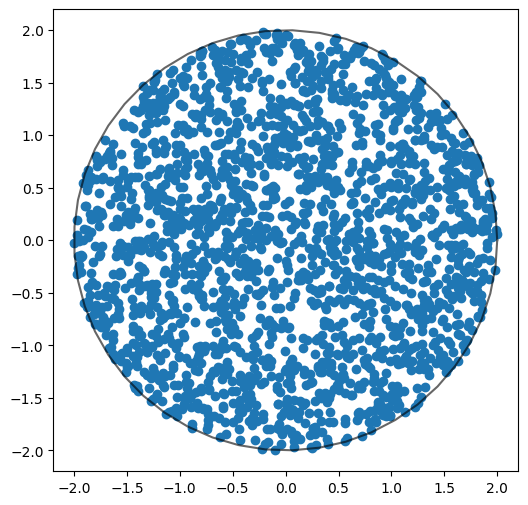

In [5]:
#checking the collocation points
plt.figure(figsize=(6, 6))

#circle
a = np.linspace(0, 2*np.pi, 50)
cx,cy = np.cos(a) * radius , np.sin(a)*radius

plt.plot(cx,cy,'k-', alpha=.6)
plt.scatter(x_c,y_c)

In [6]:
class TrainingData(Dataset):
    def __init__(self, X_c):
        self.X_c = X_c

    def __len__(self):
        return self.X_c.shape[1]

    def __getitem__(self, index):
        X_c = self.X_c[:, index]
        return X_c

## 4) Training loop function

In [7]:
def train_one_epoch(model, optimizer, zeta, eps, losses):
    running_loss = 0.
    last_loss = 0.
    n_display = (N_c//batch_size)//3

    for i, X_c in enumerate(dataloader):

        x_c = X_c[0,:]
        y_c = X_c[1,:]

        optimizer.zero_grad()

        # Compute the loss and its gradients
        loss = loss_function(model, x_c, y_c, zeta, eps)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()
        if (i+1) % n_display == 0 :
            last_loss = running_loss / n_display # loss per batch
            print('  batch {} loss: {}'.format(i + 1, last_loss))
            losses.append(last_loss)
            running_loss = 0.

    return last_loss

## 5) Launching the training

In [8]:
nb_curriculum = 1
zetas = [zeta] #* nb_curriculum
epsis = [eps] #np.linspace(zeta * nb_curriculum, eps, nb_curriculum).tolist()
losses = [[] for _ in range(nb_curriculum)]

#training parameters
batch_size = 128
learning_rate_adam = 1e-2
learning_rate_sgd = 5e-2
method = 'Adam' #'SGD' or 'Adam', Adam strongly recommended
n_epochs = 20_000
n_decreases = 200
damping = 1e-4
gamma = damping**(1/n_decreases) #damp the learning rate by a factor of 'damping' by the end of training

#first training batch
#convert numpy array to tensor and load it
X_c_train_tensor = torch.from_numpy(X_c_train).requires_grad_(True).float()
dataset = TrainingData(X_c_train_tensor)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [ ]:
for i in range(nb_curriculum):

    print("------CURRICULUM TRAINING: {0}/{1}------".format(i+1, nb_curriculum))

    #update parameter values
    zeta = zetas[i]
    eps = epsis[i]

    #load model and set optimizer
    model = CurriculumPINN(power=power, width=width, depth=depth)
    if i > 0:
        model.load_state_dict(\
        torch.load(f'curriculum_pinn_{method}.pt'))
    else:
        model.apply(init_weights)

    if method == 'Adam':
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate_adam)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=n_epochs//n_decreases,
                                                gamma=gamma)

    elif method == 'SGD':
        optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate_sgd)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=n_epochs//n_decreases,
                                                gamma=gamma)

    #train model for current curriculum
    epoch_number = 0

    for epoch in range(n_epochs):
        epoch_number += 1
        print('EPOCH {}:'.format(epoch_number))

        # Make sure gradient tracking is on, and do a pass over the data
        model.train(True)
        avg_loss = train_one_epoch(model, optimizer, zeta, eps, losses[i])
        scheduler.step()
        print('LOSS train {}'.format(avg_loss))

    #save trained model [and reset optimizer?????]
    torch.save({'epoch': n_epochs,
               'model_state_dict': model.state_dict(),
               'optimizer_state_dict': optimizer.state_dict(),
               'loss': avg_loss
               }, f'curriculum_pinn_{method}.pt')

    #regenerate collocation points
    #definition of X_c_train : N_c points in the disk
    t = np.random.uniform(0,2*np.pi, N_c)
    rho = np.sqrt(np.random.uniform(0,radius**2, N_c)) #uniform distribution on the disk
    x_c = rho * np.cos(t)
    y_c = rho * np.sin(t)
    X_c_train = np.vstack( (x_c, y_c) )
    #shuffling X_c_train
    index = np.arange(0, N_c)
    np.random.shuffle(index)
    X_c_train = X_c_train[:,index]

    #convert numpy array to tensor and load it
    X_c_train_tensor = torch.from_numpy(X_c_train).requires_grad_(True).float()
    dataset = TrainingData(X_c_train_tensor)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [10]:
# #if training got interrupted manually, save
# torch.save({'epoch': n_epochs,
#                'model_state_dict': model.state_dict(),
#                'optimizer_state_dict': optimizer.state_dict(),
#                'loss': avg_loss
#                }, f'curriculum_pinn_{method}.pt')

## 6) Visualizing the training

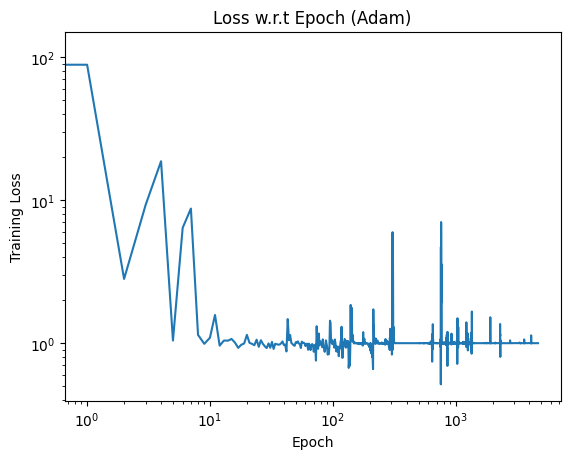

In [11]:
plt.loglog(losses[0])
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title('Loss w.r.t Epoch ({0})'.format(method))
plt.show()

## 6bis) Training for longer if convergence isn't attained [optional]

In [ ]:
#reloading the previously saved checkpoint
checkpoint = torch.load(f'curriculum_pinn_{method}.pt')

#intialization of the model and optimizer
model = CurriculumPINN(power=power, width=width, depth=depth)

extra_epochs = 10_000
n_decreases = 100
learning_rate_adam = 1e-4
damping = 1e-2
gamma = damping**(1/n_decreases)

if method == 'Adam':
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate_adam)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer,\
                                                    step_size=extra_epochs//n_decreases,\
                                                    gamma=gamma)


#reloading of parameters from end of previous training
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
start_epoch = checkpoint['epoch']
loss = checkpoint['loss']

#retrain for 'extra_epochs'
for epoch in range(start_epoch+1, start_epoch + extra_epochs):
        #epoch_number += 1
        print('EPOCH {}:'.format(epoch))

        # Make sure gradient tracking is on, and do a pass over the data
        model.train(True)
        avg_loss = train_one_epoch(model, optimizer, zeta, eps, losses[i])
        scheduler.step()
        print('LOSS train {}'.format(avg_loss))

#save the further trained model and reset optimizer
torch.save({'epoch': start_epoch + extra_epochs,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': avg_loss
            }, f'curriculum_pinn_{method}.pt')

In [ ]:
plt.loglog(losses[0])
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title('Loss w.r.t Epoch ({0})'.format(method))
plt.show()

## 7) Visualizing the learned solution

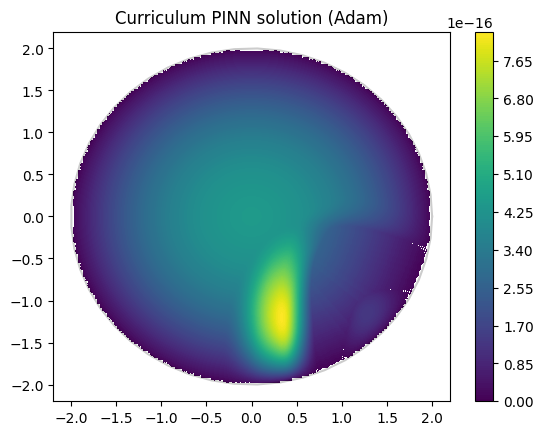

In [12]:
#load the model
checkpoint = torch.load(f'curriculum_pinn_{method}.pt')
model = CurriculumPINN(power=power, width=width, depth=depth)
model.load_state_dict(checkpoint['model_state_dict'])

#evaluate the model on a uniform grid
n_points = 150
tt = np.linspace(-1, 1, n_points) * radius
xx, yy = np.meshgrid(tt, tt)  # create unit square grid
xx, yy = np.where(xx**2 + yy**2 <= radius**2, xx, 0), np.where(xx**2 + yy**2 <= radius**2 , yy, 0) #(https://stackoverflow.com/questions/15733530/)
#zz_true = true_solution_vectorized(xx,yy)

input = torch.from_numpy(np.vstack((xx.ravel(),yy.ravel())).T).float()#.requires_grad_(False)
learned_sol = model(input)

#plot
learned_sol_np = learned_sol.detach().numpy().reshape(xx.shape)
#learned_sol_smooth = ndimage.gaussian_filter(learned_sol_np, sigma=0.1, order=0) #smoothing for visualization

fig, ax = plt.subplots()
ax.plot(cx, cy,'k-', alpha=.2)
contour = ax.contourf(xx, yy, learned_sol_np, levels=200)
ax.set_title(f'Curriculum PINN solution ({method})')
cb = fig.colorbar(contour, ax=ax)

In [ ]:
#verify that the model is zero on the boundary
circle = torch.from_numpy(np.vstack((cx.ravel(),cy.ravel())).T).float().requires_grad_(False)
torch.sum(model(circle)**2) #== 0